<a href="https://colab.research.google.com/github/CeesGniewyk/Recommender-Systems/blob/master/Assignment_2_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

# Packages

## Data

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Lambda, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.regularizers import l2
from keras.losses import binary_crossentropy
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

## Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Preprocessing

In [0]:
classes = "beaver dolphin otter seal whale aquarium-fish flatfish ray shark trout orchids poppies roses sunflowers tulips bottles bowls cans cups plates apples mushrooms oranges pears sweet-peppers clock computer-keyboard lamp telephone television bed chair couch table wardrobe bee beetle butterfly caterpillar cockroach bear leopard lion tiger, wolf bridge, castle, house, road, skyscraper cloud, forest, mountain, plain, sea camel, cattle, chimpanzee, elephant, kangaroo fox, porcupine, possum, raccoon, skunk crab, lobster, snail, spider, worm baby, boy, girl, man, woman crocodile, dinosaur, lizard, snake, turtle hamster, mouse, rabbit, shrew, squirrel maple, oak, palm, pine, willow bicycle, bus, motorcycle, pickup-truck, train lawn-mower, rocket, streetcar, tank, tractor"
class_labels = classes.replace(",","").split()
class_labels.sort()
print(class_labels)

['apples', 'aquarium-fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer-keyboard', 'couch', 'crab', 'crocodile', 'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup-truck', 'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflowers', 'sweet-peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow',

Class label: cattle


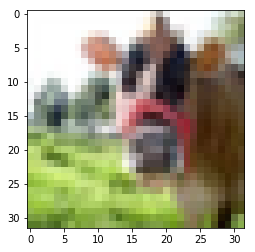

In [0]:
example_id = 0 # pick any integer from 0 to 49999 to visualize a training example
example = x_train[example_id]
label = y_train[example_id]
print("Class label:", class_labels[label[0]])
plt.imshow(example)
plt.show()

## Splitting the Data

In [0]:
selection = y_train < 80
selection = selection.reshape(50000)
invertselection = selection == False
#Note the X,Y are capitalized for the split data
Y_train = y_train[selection]
X_train = x_train[selection]
Y_oneshot_train = y_train[invertselection] 
X_oneshot_train = x_train[invertselection]
print(Y_train.shape)
print(X_train.shape)
print(Y_oneshot_train.shape)
print(X_oneshot_train.shape)

(40000, 1)
(40000, 32, 32, 3)
(10000, 1)
(10000, 32, 32, 3)


In [0]:
training = np.zeros((80,500,32,32,3))
for category in range(80):
    example_nr = 0
    for j in range(len(X_train)):
        if (Y_train[j][0] == category):
            training[category][example_nr]=X_train[j]
            example_nr +=1            

Class label: bridge


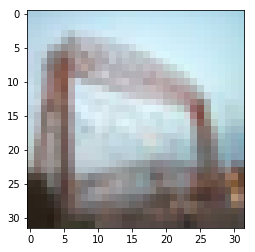

In [0]:
example_class = 12# pick any integer from 0 to 79
example_nr = 2 # pick any integer from 0 to 499 to visualize a training example
example = training[example_class][example_nr]
print("Class label:", class_labels[example_class])
plt.imshow(example.astype(np.uint8))
plt.show()

In [0]:
One_shot_testing = np.zeros((20,500,32,32,3))
for category in range(80,100):
    example_nr = 0
    realcategory = category-80
    for j in range(len(X_oneshot_train)):
        if (Y_oneshot_train[j][0] == category):
            One_shot_testing[realcategory][example_nr]=X_oneshot_train[j]
            example_nr +=1            

Class label: television


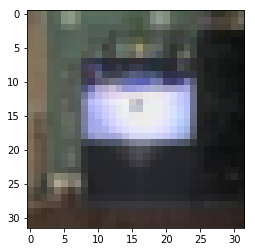

In [0]:
example_class = 7 # pick any integer from 0 to 19
example_nr = 50 # pick any integer from 0 to 499 to visualize a training example
example = One_shot_testing[example_class][example_nr]
print("Class label:", class_labels[example_class+80])
plt.imshow(example.astype(np.uint8))
plt.show()

# Question 1: Siamese networks & one-shot learning (7pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

### Methods

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h,d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h,d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, training), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
# convnet.add(MaxPooling2D()) I think max pooling over an image where it doesn't fit causes errors
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       200832    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_2

In [0]:
def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

### Run cell

In [0]:

path = "content/gdrive/My Drive/Project Support List/Colab Notebooks/models"
loops = 10
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, X_train)
    test_acc = test_oneshot(siamese_net, One_shot_testing)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save('model.h5')
        best_acc = test_acc
model_file = drive.CreateFile({'title' : 'model.h5'})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})    

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 7s 75ms/step - loss: 0.6863
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 8s 75ms/step - loss: 0.6864
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 8s 75ms/step - loss: 0.6909
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 7s 75ms/step - loss: 0.6847
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-wa

GoogleDriveFile({'id': '14SdEFTp1LQuqeonHo8DFX08usE2c2zHQ'})

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:** <br>


The overall accuracy is 12.0%, which better than a random guess <br>

<b>Differences regarding the images itself:</b>
<br>The data is RGB instead of 1 dimensional, The images of the Cifar-100 data set are more noisy, the language dataset is very clean, The images in the CIFAR-100 dataset have a much lower resolution <br>
<b> Differences regarding the classes and availability of data:</b> 
<br>The omniglot training dataset has metaclasses: 30 languages in the training set and 20 languages in the test set, each with an average of about 32 characters. Each character has 20 examples <br>
the Cifar-100 dataset has 80 classes in the training set, 20 in the test set with 500 examples for each class.
<br><br>
<b> Overall influence of differences: </b> <br>
In comparison the Cifar-100 dataset has more data images per class, but also has less detailed images. <br>
These differences are making it more difficult for the model to find the differences between the images in the Cifar-100 data set compared to the Omniglot. The model will most likely run faster due to the lower resolutions, but will have a higher difficulty finding characteristics that distinguish the different models.

***

# Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [0]:
# === add code here ===

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

The architecture that would have been implemented would have been the architecture in Task 1.1 without the last layer of the siamese network. To get the neural codes the last dense layer is used. The difference in architecture would most likely be that the CNN neural codes approach uses more information to come to a decision. <br>
The CNN is trained to classify the images to the appropriate class <br> the Siamese network is a neural network made to compare the neural codes of two images and train the network on the misclassification of the pairs of images (Either similar or dissimilar) <br>
The Siamese network is only concerned about the differences between 2 images in every training step, whereas the CNN for the neural codes is doing a 80-way classification. <br> 
The models learn in different ways, therefore the One-shot task will have different outcomes. <br>
Furthermore, for the siamese network the model is retrained after each batch of one-shot tasks. The CNN for the neural codes isn't retrained.

***
# Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

```python
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        
    
    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
    margin = # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss
```


In [0]:
# === add code here ===

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

In [0]:
# === add code here ===

***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

<b>Answer</b> <br>
Random guessing on the *whole dataset* would be a 1% chance of getting it right. <br>
We are however using the one-shot method where we use 20 of the classes, which gives the random guess a 5% accuracy <br>


**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

The Triplet Neural codes are expected to score the highest.

***
## Question 4: Peer review (0pt)

Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?

Timothy: We kinda failed on this assignment as a group, as all of us were a little undetermined over the week and didn't start on time and communicated enough with eachother. This is a takeaway for the next assignment.

Cees: All of us underestimated the workload and the time spent on pre-processing. It took me quite some time to get the data in the correct format. I've learned a lot, but didn't make a lot of progress. I know how to approach the problem, but simply didn't have enough time to implement it. Unfortunate, but better planning next time.

Celine: